In [ ]:
%%capture
"""Rocket transformer."""
__author__ = ["angus924"]
__all__ = ["Rocket"]

import numpy as np
from numba import get_num_threads, njit, prange, set_num_threads #Numba is used for Just-In-Time (JIT) compilation to speed up the execution of certain functions.

!pip install aeon[all_extras] --quiet
from aeon.transformations.collection import BaseCollectionTransformer
from aeon.utils.validation import check_n_jobs


class Rocket(BaseCollectionTransformer):
    """RandOm Convolutional KErnel Transform (ROCKET).

    A kernel (or convolution) is a subseries used to create features that can be used
    in machine learning tasks. ROCKET [1]_  generates a large number of random
    convolutional kernels in the fit method. The length and dilation of each kernel
    are also randomly generated. The kernels are use in the transform stage to
    generate a new set of features. A kernel is used to create an activation map for
    each series by running it across a time series, including random length and
    dilation. It transforms the time series with two features per kernel. The first
    feature is global max pooling and the second is proportion of positive values.


    Parameters
    ----------
    num_kernels : int, default=10,000
       Number of random convolutional kernels.
    normalise : bool, default True
       Whether or not to normalise the input time series per instance.
    n_jobs : int, default=1
       The number of jobs to run in parallel for `transform`. ``-1`` means use all
       processors.
    random_state : None or int, optional, default = None

    See Also
    --------
    MultiRocketMultivariate, MiniRocket, MiniRocketMultivariate

    References
    ----------
    .. [1] Tan, Chang Wei and Dempster, Angus and Bergmeir, Christoph
        and Webb, Geoffrey I,
        "ROCKET: Exceptionally fast and accurate time series
      classification using random convolutional kernels",2020,
      https://link.springer.com/article/10.1007/s10618-020-00701-z,
      https://arxiv.org/abs/1910.13051

    Examples
    --------
    >>> from aeon.transformations.collection.convolution_based import Rocket
    >>> from aeon.datasets import load_unit_test
    >>> X_train, y_train = load_unit_test(split="train")
    >>> X_test, y_test = load_unit_test(split="test")
    >>> trf = Rocket(num_kernels=512)
    >>> trf.fit(X_train)
    Rocket(num_kernels=512)
    >>> X_train = trf.transform(X_train)
    >>> X_test = trf.transform(X_test)
    """

    _tags = {
        "output_data_type": "Tabular",
        "capability:multivariate": True,
        "algorithm_type": "convolution",
    }

    def __init__(self, num_kernels=10_000, normalise=True, n_jobs=1, random_state=None):
        self.num_kernels = num_kernels
        self.normalise = normalise
        self.n_jobs = n_jobs
        self.random_state = random_state
        super(Rocket, self).__init__()

    def _fit(self, X, y=None):#The class has a private method _fit for generating random kernels adjusted to time series shape.
        """Generate random kernels adjusted to time series shape.

        Infers time series length and number of channels from input numpy array,
        and generates random kernels.

        Parameters
        ----------
        X : 3D np.ndarray of shape = (n_instances, n_channels, n_timepoints)
            collection of time series to transform
        y : ignored argument for interface compatibility

        Returns
        -------
        self
        """
        if isinstance(self.random_state, int):
            self._random_state = self.random_state
        else:
            self._random_state = None

        _, n_channels, n_timepoints = X.shape
        self.kernels = _generate_kernels(
            n_timepoints, self.num_kernels, n_channels, self._random_state
        )
        return self

    def _transform(self, X, y=None):# _transform applies the generated kernels to input time series data.
        """Transform input time series using random convolutional kernels.

        Parameters
        ----------
        X : 3D np.ndarray of shape = [n_instances, n_channels, series_length]
            collection of time series to transform
        y : ignored argument for interface compatibility

        Returns
        -------
        np.ndarray [n_instances, num_kernels], transformed features
        """
        if self.normalise:
            X = (X - X.mean(axis=-1, keepdims=True)) / (
                X.std(axis=-1, keepdims=True) + 1e-8
            )
        prev_threads = get_num_threads()

        n_jobs = check_n_jobs(self.n_jobs)

        set_num_threads(n_jobs)
        X_ = _apply_kernels(X.astype(np.float32), self.kernels)
        set_num_threads(prev_threads)
        return X_


@njit(
    "Tuple((float32[:],int32[:],float32[:],int32[:],int32[:],int32[:],"
    "int32[:]))(int32,int32,int32,optional(int32))",
    cache=True,
)
def _generate_kernels(n_timepoints, num_kernels, n_channels, seed):
    if seed is not None:
        np.random.seed(seed)
    candidate_lengths = np.array((7, 9, 11), dtype=np.int32)
    lengths = np.random.choice(candidate_lengths, num_kernels).astype(np.int32)

    num_channel_indices = np.zeros(num_kernels, dtype=np.int32)
    for i in range(num_kernels):
        limit = min(n_channels, lengths[i])
        num_channel_indices[i] = 2 ** np.random.uniform(0, np.log2(limit + 1))

    channel_indices = np.zeros(num_channel_indices.sum(), dtype=np.int32)

    weights = np.zeros(
        np.int32(
            np.dot(lengths.astype(np.float32), num_channel_indices.astype(np.float32))
        ),
        dtype=np.float32,
    )
    biases = np.zeros(num_kernels, dtype=np.float32)
    dilations = np.zeros(num_kernels, dtype=np.int32)
    paddings = np.zeros(num_kernels, dtype=np.int32)

    a1 = 0  # for weights
    a2 = 0  # for channel_indices

    for i in range(num_kernels):
        _length = lengths[i]
        _num_channel_indices = num_channel_indices[i]

        #_weights = np.random.normal(0, 1, _num_channel_indices * _length).astype(np.float32) #utiliza a normal
        _weights = np.random.standard_t(df=1, size=_num_channel_indices * _length).astype(np.float32) #t-student


        b1 = a1 + (_num_channel_indices * _length)
        b2 = a2 + _num_channel_indices

        a3 = 0  # for weights (per channel)
        for _ in range(_num_channel_indices):
            b3 = a3 + _length
            _weights[a3:b3] = _weights[a3:b3] - _weights[a3:b3].mean()
            a3 = b3

        weights[a1:b1] = _weights

        channel_indices[a2:b2] = np.random.choice(
            np.arange(0, n_channels), _num_channel_indices, replace=False
        )

        biases[i] = np.random.uniform(-1, 1)#uniform distribution

        dilation = 2 ** np.random.uniform(
            0, np.log2((n_timepoints - 1) / (_length - 1))
        )
        dilation = np.int32(dilation)
        dilations[i] = dilation

        padding = ((_length - 1) * dilation) // 2 if np.random.randint(2) == 1 else 0
        paddings[i] = padding

        a1 = b1
        a2 = b2

    return (
        weights,
        lengths,
        biases,
        dilations,
        paddings,
        num_channel_indices,
        channel_indices,
    )


@njit(fastmath=True, cache=True)
def _apply_kernel_univariate(X, weights, length, bias, dilation, padding):
    n_timepoints = len(X)

    output_length = (n_timepoints + (2 * padding)) - ((length - 1) * dilation)

    _ppv = 0
    _max = np.NINF

    end = (n_timepoints + padding) - ((length - 1) * dilation)

    for i in range(-padding, end):
        _sum = bias

        index = i

        for j in range(length):
            if index > -1 and index < n_timepoints:
                _sum = _sum + weights[j] * X[index]

            index = index + dilation

        if _sum > _max:
            _max = _sum

        if _sum > 0:
            _ppv += 1

    return np.float32(_ppv / output_length), np.float32(_max)


@njit(fastmath=True, cache=True)
def _apply_kernel_multivariate(
    X, weights, length, bias, dilation, padding, num_channel_indices, channel_indices
):
    n_columns, n_timepoints = X.shape

    output_length = (n_timepoints + (2 * padding)) - ((length - 1) * dilation)

    _ppv = 0
    _max = np.NINF

    end = (n_timepoints + padding) - ((length - 1) * dilation)

    for i in range(-padding, end):
        _sum = bias

        index = i

        for j in range(length):
            if index > -1 and index < n_timepoints:
                for k in range(num_channel_indices):
                    _sum = _sum + weights[k, j] * X[channel_indices[k], index]

            index = index + dilation

        if _sum > _max:
            _max = _sum

        if _sum > 0:
            _ppv += 1

    return np.float32(_ppv / output_length), np.float32(_max)


@njit(
    "float32[:,:](float32[:,:,:],Tuple((float32[::1],int32[:],float32[:],"
    "int32[:],int32[:],int32[:],int32[:])))",
    parallel=True,
    fastmath=True,
    cache=True,
)
def _apply_kernels(X, kernels):
    (
        weights,
        lengths,
        biases,
        dilations,
        paddings,
        num_channel_indices,
        channel_indices,
    ) = kernels

    n_instances, n_channels, _ = X.shape
    num_kernels = len(lengths)

    _X = np.zeros(
        (n_instances, num_kernels * 2), dtype=np.float32
    )  # 2 features per kernel

    for i in prange(n_instances):
        a1 = 0  # for weights
        a2 = 0  # for channel_indices
        a3 = 0  # for features

        for j in range(num_kernels):
            b1 = a1 + num_channel_indices[j] * lengths[j]
            b2 = a2 + num_channel_indices[j]
            b3 = a3 + 2

            if num_channel_indices[j] == 1:
                _X[i, a3:b3] = _apply_kernel_univariate(
                    X[i, channel_indices[a2]],
                    weights[a1:b1],
                    lengths[j],
                    biases[j],
                    dilations[j],
                    paddings[j],
                )

            else:
                _weights = weights[a1:b1].reshape((num_channel_indices[j], lengths[j]))

                _X[i, a3:b3] = _apply_kernel_multivariate(
                    X[i],
                    _weights,
                    lengths[j],
                    biases[j],
                    dilations[j],
                    paddings[j],
                    num_channel_indices[j],
                    channel_indices[a2:b2],
                )

            a1 = b1
            a2 = b2
            a3 = b3

    return _X.astype(np.float32)


In [ ]:
# from aeon.transformations.collection.convolution_based import Rocket
from aeon.datasets._data_loaders import load_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import numpy as np

!pip install fastcluster --quiet


x_train, y_train = load_classification("CinCECGTorso", split='train')
x_test, y_test = load_classification("CinCECGTorso", split='test')
rck = Rocket(num_kernels=10000)

x_train_feat = rck.fit_transform(x_train)
x_test_feat = rck.fit_transform(x_test)

x_transformado = rck._transform(x_train) #matriz transformada com ppv(pares) e max(ímpares)

    # >>> from aeon.datasets import load_unit_test
    # >>> X_train, y_train = load_unit_test(split="train")
    # >>> X_test, y_test = load_unit_test(split="test")
    # >>> trf = Rocket(num_kernels=512)
    # >>> trf.fit(X_train)
    # Rocket(num_kernels=512)
    # >>> X_train = trf.transform(X_train)
    # >>> X_test = trf.transform(X_test)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.0/194.0 kB 1.6 MB/s eta 0:00:00


Text(0, 0.5, 'Amplitude')

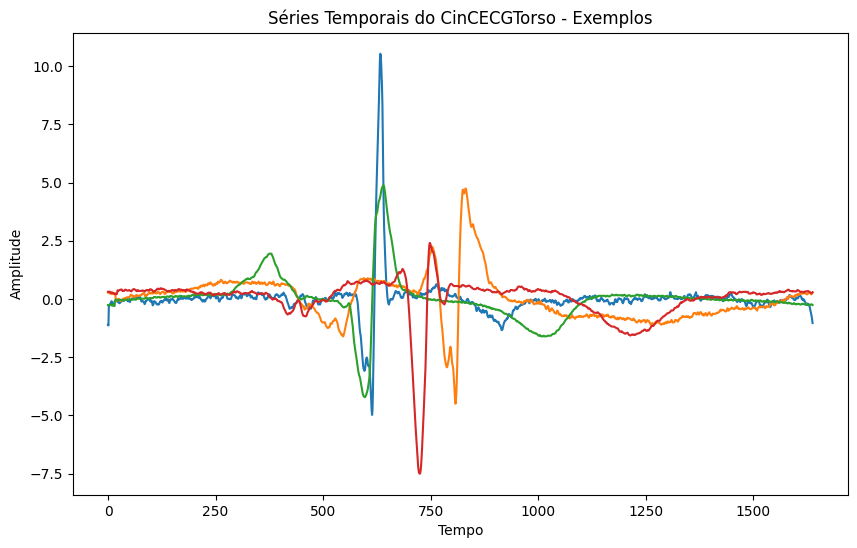

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x_train[0][0])
plt.plot(x_train[1][0])
plt.plot(x_train[2][0])
plt.plot(x_train[39][0])
plt.title('Séries Temporais do CinCECGTorso - Exemplos')
plt.xlabel('Tempo')
plt.ylabel('Amplitude')

In [ ]:
x_train_feat.shape

(40, 20000)

In [ ]:
x_transformado[:,:10:2] # ppv

array([[0.20818378, 0.6320927 , 0.38987187, 0.48155096, 0.43646806],
       [0.23833454, 0.6186699 , 0.39231238, 0.4534084 , 0.50323045],
       [0.25699928, 0.56253815, 0.5228798 , 0.34521577, 0.40775305],
       [0.22397703, 0.71446   , 0.47345942, 0.49656036, 0.5965542 ],
       [0.32447955, 0.5637584 , 0.35875535, 0.5121951 , 0.53984207],
       [0.27781767, 0.55887735, 0.5320317 , 0.5134459 , 0.5477387 ],
       [0.11844939, 0.6967663 , 0.60158634, 0.47592247, 0.51399857],
       [0.19956927, 0.5655888 , 0.5289811 , 0.4390244 , 0.39124194],
       [0.24551328, 0.6125686 , 0.4813911 , 0.34646654, 0.24120604],
       [0.13208902, 0.7169005 , 0.54118365, 0.49718574, 0.5362527 ],
       [0.19813353, 0.6485662 , 0.61744964, 0.52845526, 0.49174443],
       [0.25197417, 0.5771812 , 0.5106772 , 0.4440275 , 0.4874372 ],
       [0.19095477, 0.5302013 , 0.47223917, 0.44027516, 0.28930366],
       [0.2713568 , 0.5899939 , 0.47467968, 0.4721701 , 0.41852117],
       [0.28715003, 0.64063454, 0.

In [ ]:
x_transformado[:,1:10:2] # max

array([[  43.095364 ,   26.104317 ,  818.3418   ,   81.60698  ,
          61.376324 ],
       [  23.021526 ,   18.787893 ,  832.60236  ,   73.876755 ,
          52.091846 ],
       [  25.25289  ,   22.975342 ,  775.8659   ,   73.557686 ,
          52.389862 ],
       [  29.559277 ,   16.247314 ,  676.3894   ,   56.940533 ,
          40.078716 ],
       [  24.353811 ,   24.519096 ,  987.9339   ,   69.981804 ,
          64.70976  ],
       [  22.713278 ,   16.704271 ,  933.05615  ,   32.329998 ,
          50.161396 ],
       [  28.47385  ,   14.5937395,  740.6083   ,   47.93755  ,
          40.43265  ],
       [  16.111526 ,   24.725992 , 1055.0558   ,   31.772339 ,
          49.49725  ],
       [  20.78768  ,   25.409721 , 1140.7883   ,   47.239178 ,
          58.778145 ],
       [  27.69625  ,   14.174591 ,  752.2754   ,   48.18145  ,
          43.939693 ],
       [  26.358147 ,   13.686573 ,  681.9196   ,   41.170204 ,
          41.39102  ],
       [  16.367523 ,   16.59165  ,  772.21

<function matplotlib.pyplot.show(close=None, block=None)>

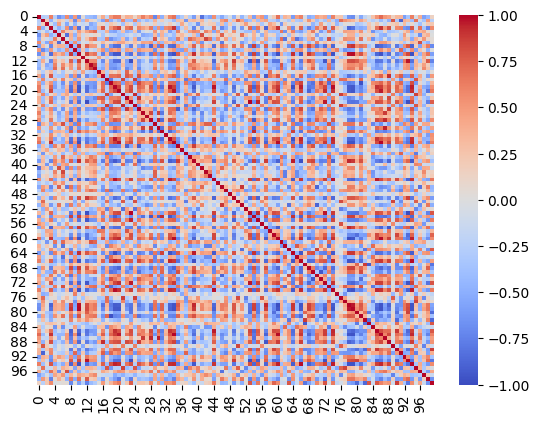

In [ ]:
#Análise dos valores do ppv
correlation_matrix1 = np.corrcoef(x_transformado[:,0:200:2].T)#seleciona as linhas pulando de 2 em 2(0,2,4,6,..., pares valores PPV)
sns.heatmap(correlation_matrix1, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.show

In [ ]:
np.min(correlation_matrix1)

-0.9924220977137628

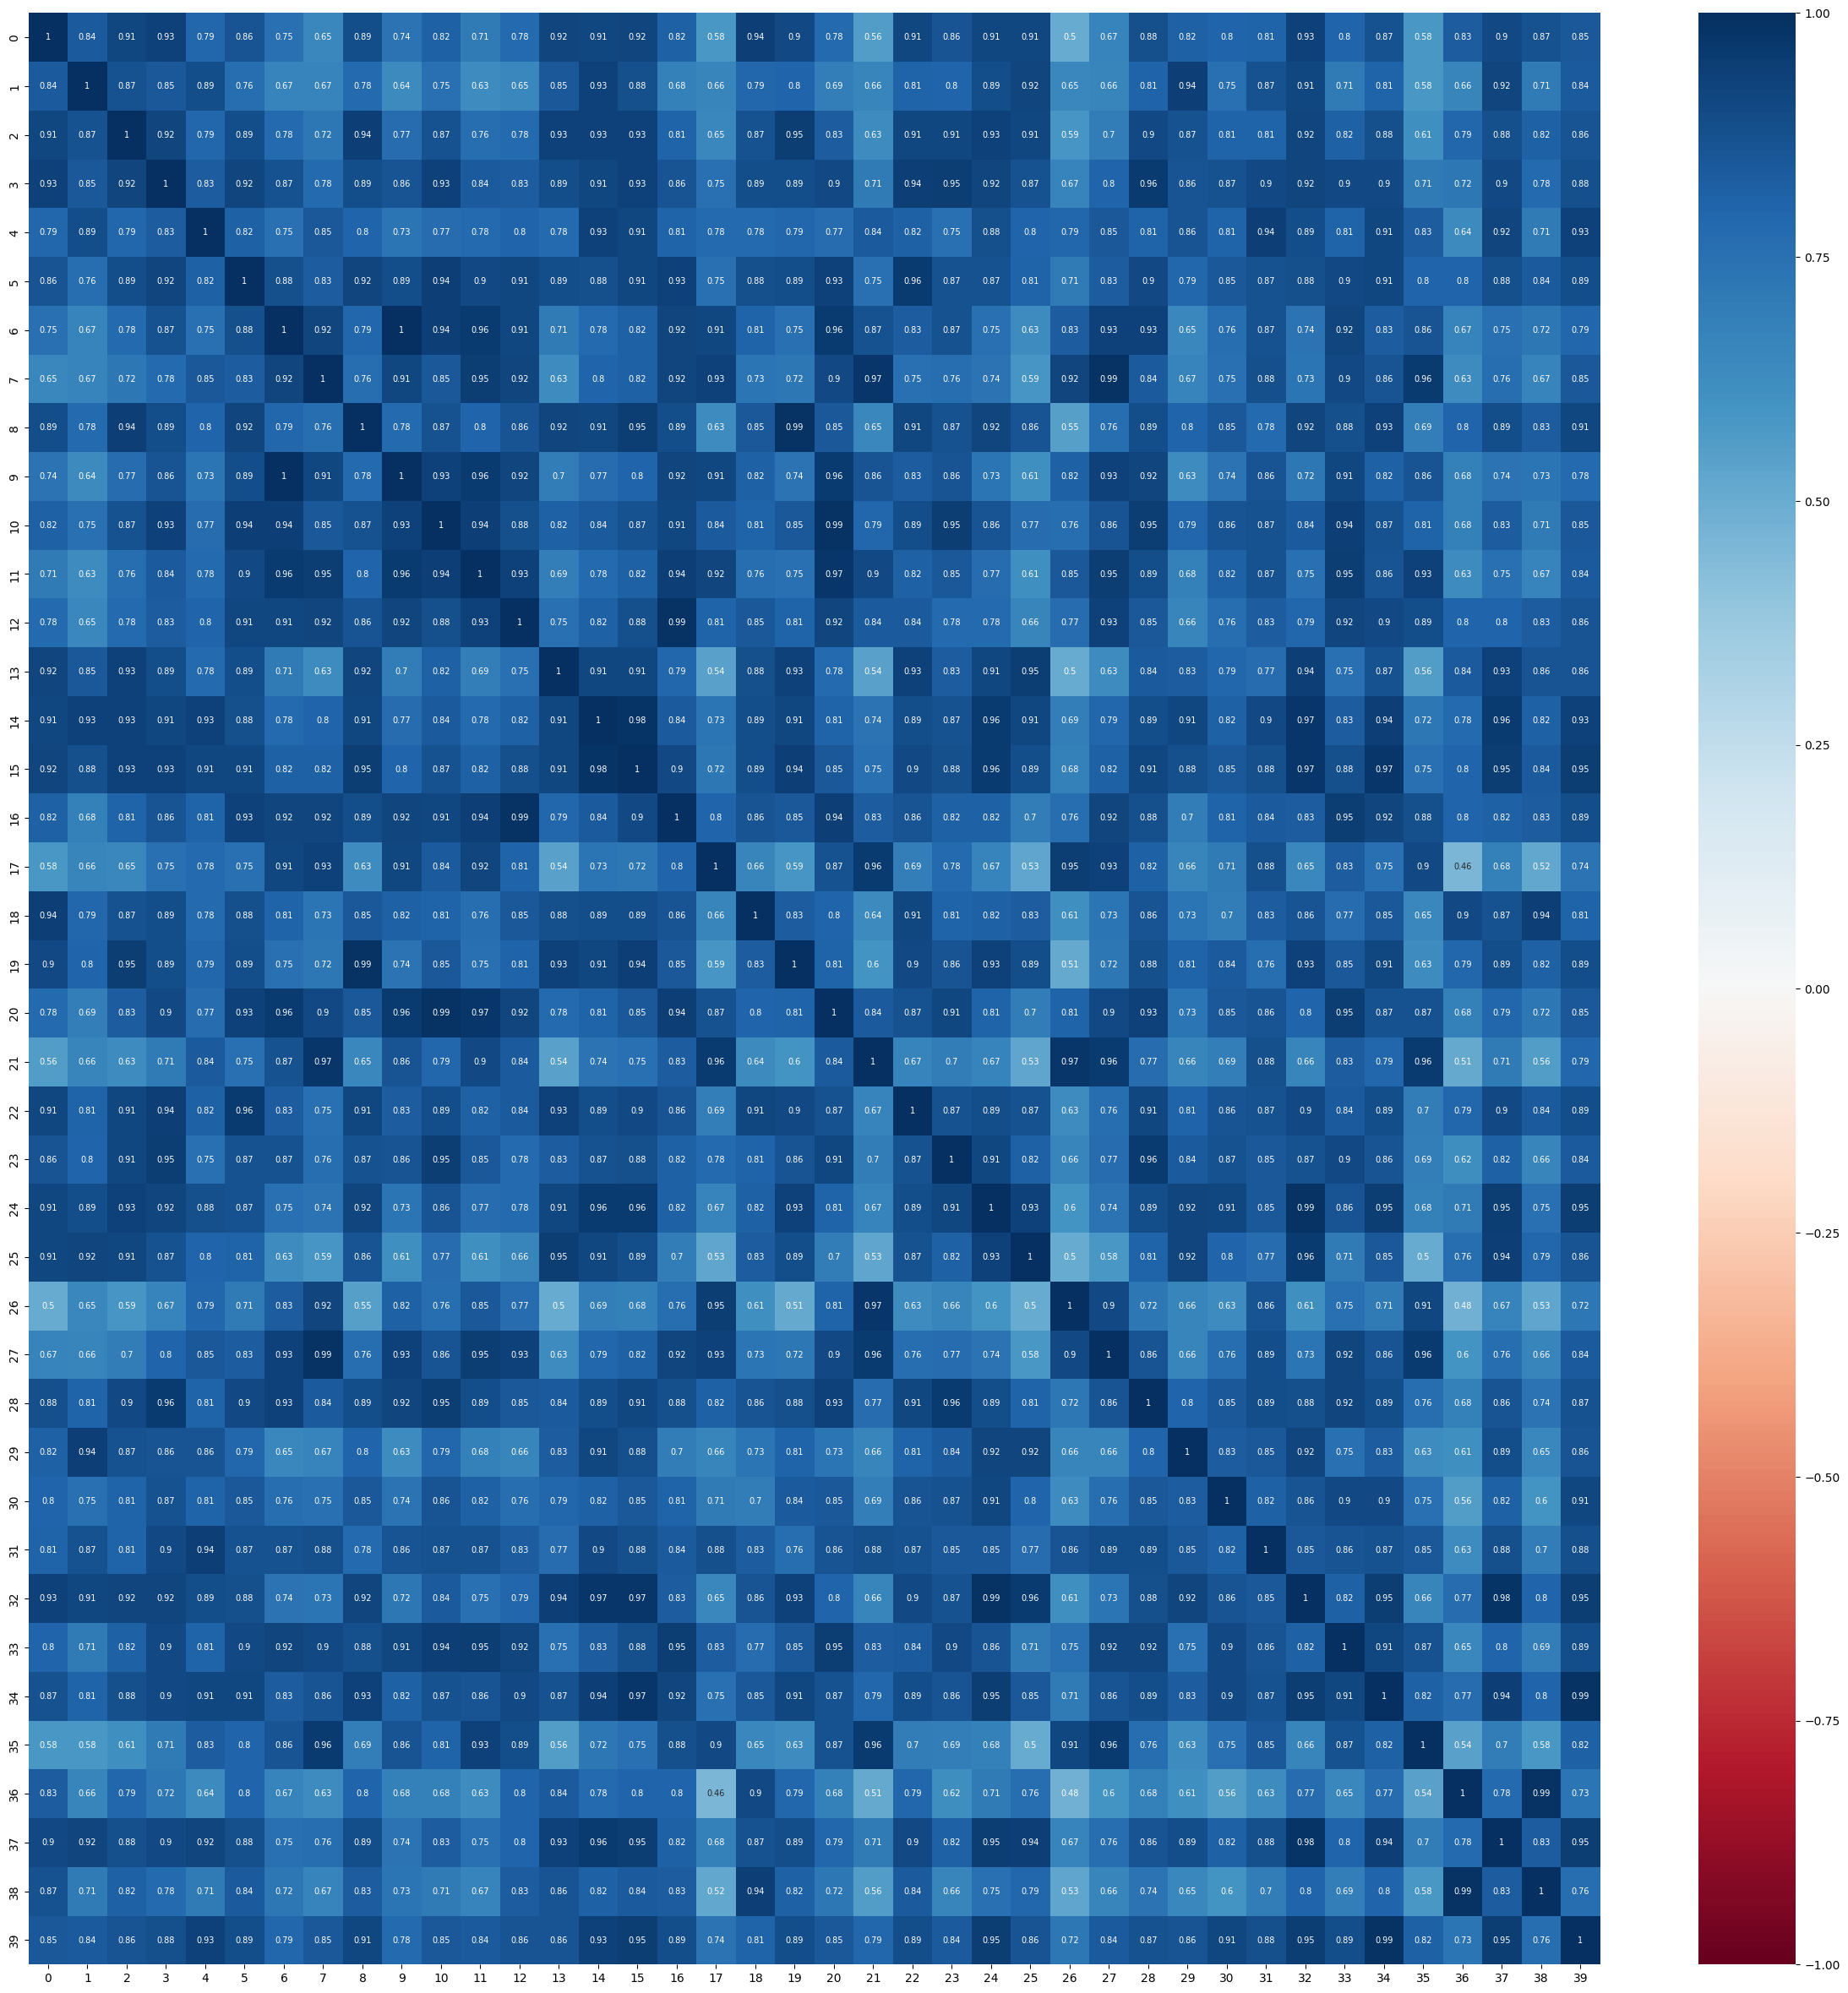

In [ ]:
ecg200ppv = pd.DataFrame(x_transformado[:,0:100:2].T)
plt.figure(figsize=(30,30))
correlations1 = ecg200ppv.corr()
sns.heatmap(round(correlations1,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);

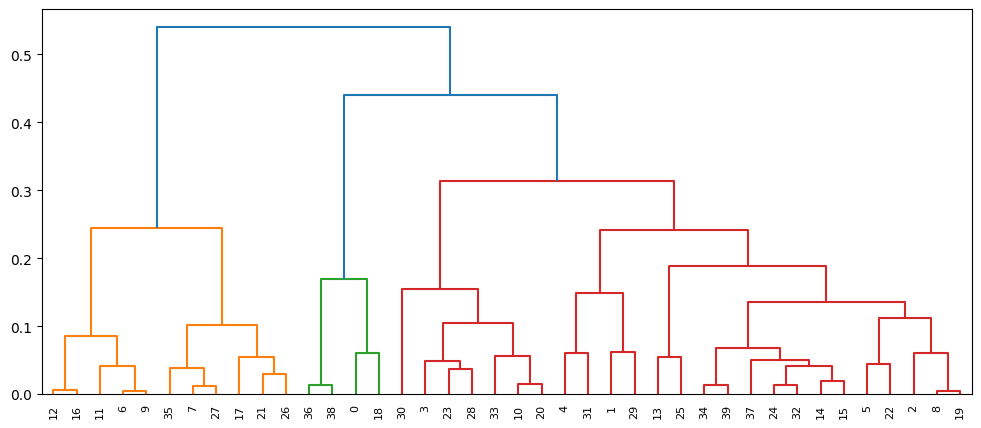

In [ ]:
plt.figure(figsize=(12,5))
dissimilarity1 = 1 - abs(correlations1)
Z = linkage(squareform(dissimilarity1), 'complete')

dendrogram(Z, labels=ecg200ppv.columns, orientation='top',
           leaf_rotation=90);

In [ ]:
# Clusterize the data
threshold = 0.000005 #dissimilaridade (distancia) entre dois clusters
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

array([14, 25, 40, 18, 23, 36,  3,  6, 38,  4, 19,  5,  1, 27, 33, 34,  2,
       11, 15, 39, 20,  9, 37, 16, 31, 28, 10,  7, 17, 26, 22, 24, 32, 21,
       29,  8, 12, 35, 13, 30], dtype=int32)

In [ ]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(ecg200ppv.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(ecg200ppv[i])
    else:
        df_to_append = pd.DataFrame(ecg200ppv[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

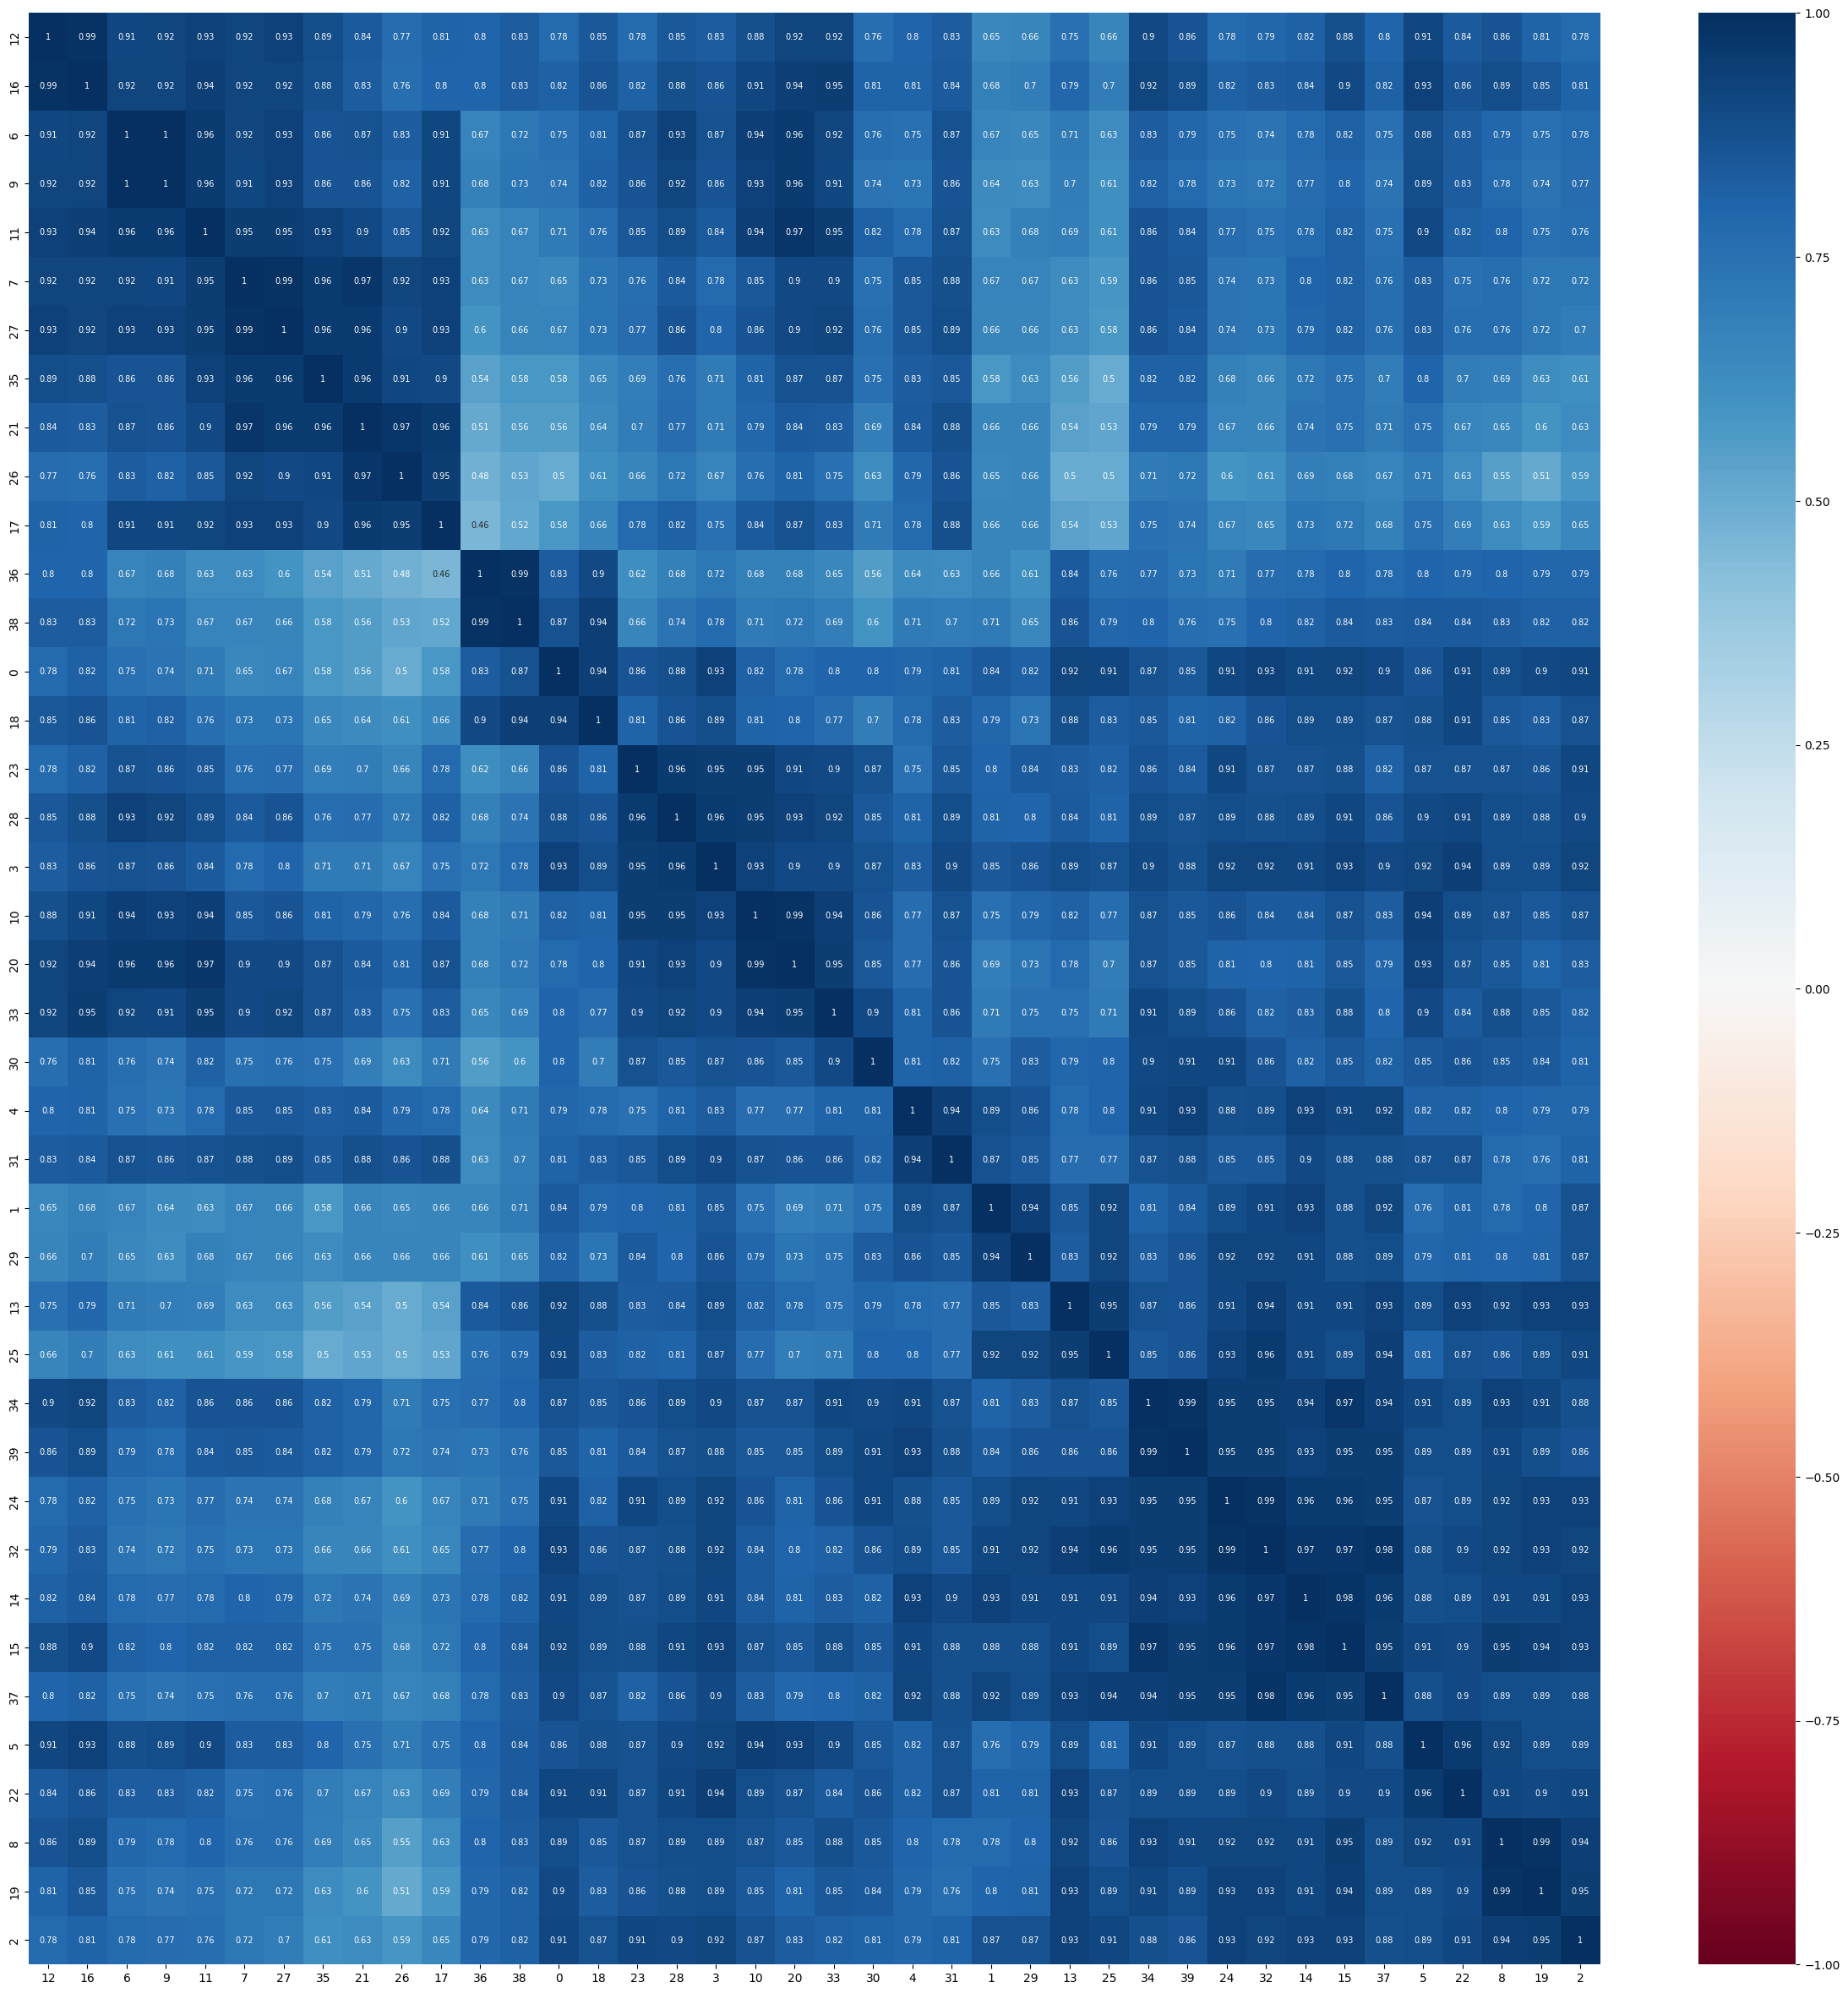

In [ ]:
plt.figure(figsize=(30,30))
correlations1 = clustered.corr()
sns.heatmap(round(correlations1,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);

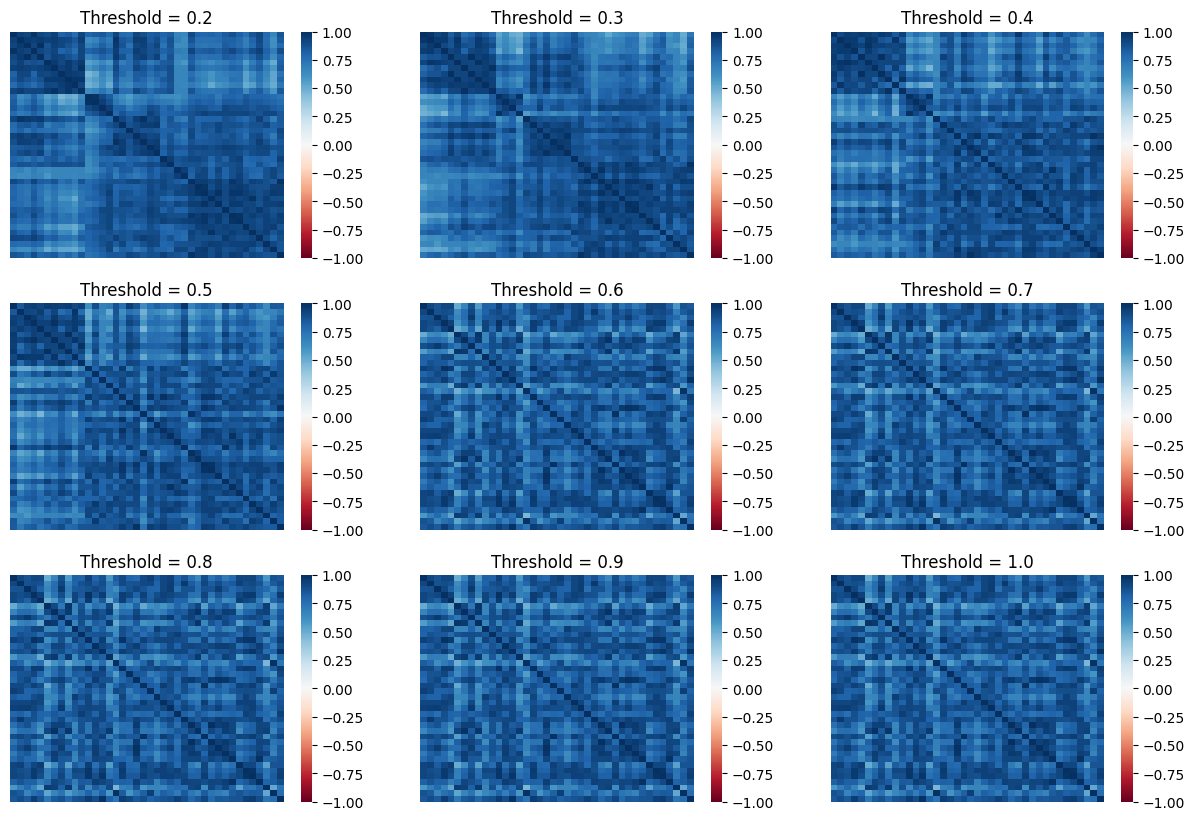

In [ ]:
plt.figure(figsize=(15,10))

for idx, t in enumerate(np.arange(0.2,1.1,0.1)):

    # Subplot idx + 1
    plt.subplot(3, 3, idx+1)

    # Calculate the cluster
    labels = fcluster(Z, t, criterion='distance')

    # Keep the indices to sort labels
    labels_order = np.argsort(labels)

    # Build a new dataframe with the sorted columns
    for idx, i in enumerate(ecg200ppv.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(ecg200ppv[i])
        else:
            df_to_append = pd.DataFrame(ecg200ppv[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)

    # Plot the correlation heatmap
    correlations1 = clustered.corr()
    sns.heatmap(round(correlations1,2), cmap='RdBu', vmin=-1, vmax=1,
                xticklabels=False, yticklabels=False)
    plt.title("Threshold = {}".format(round(t,2)))

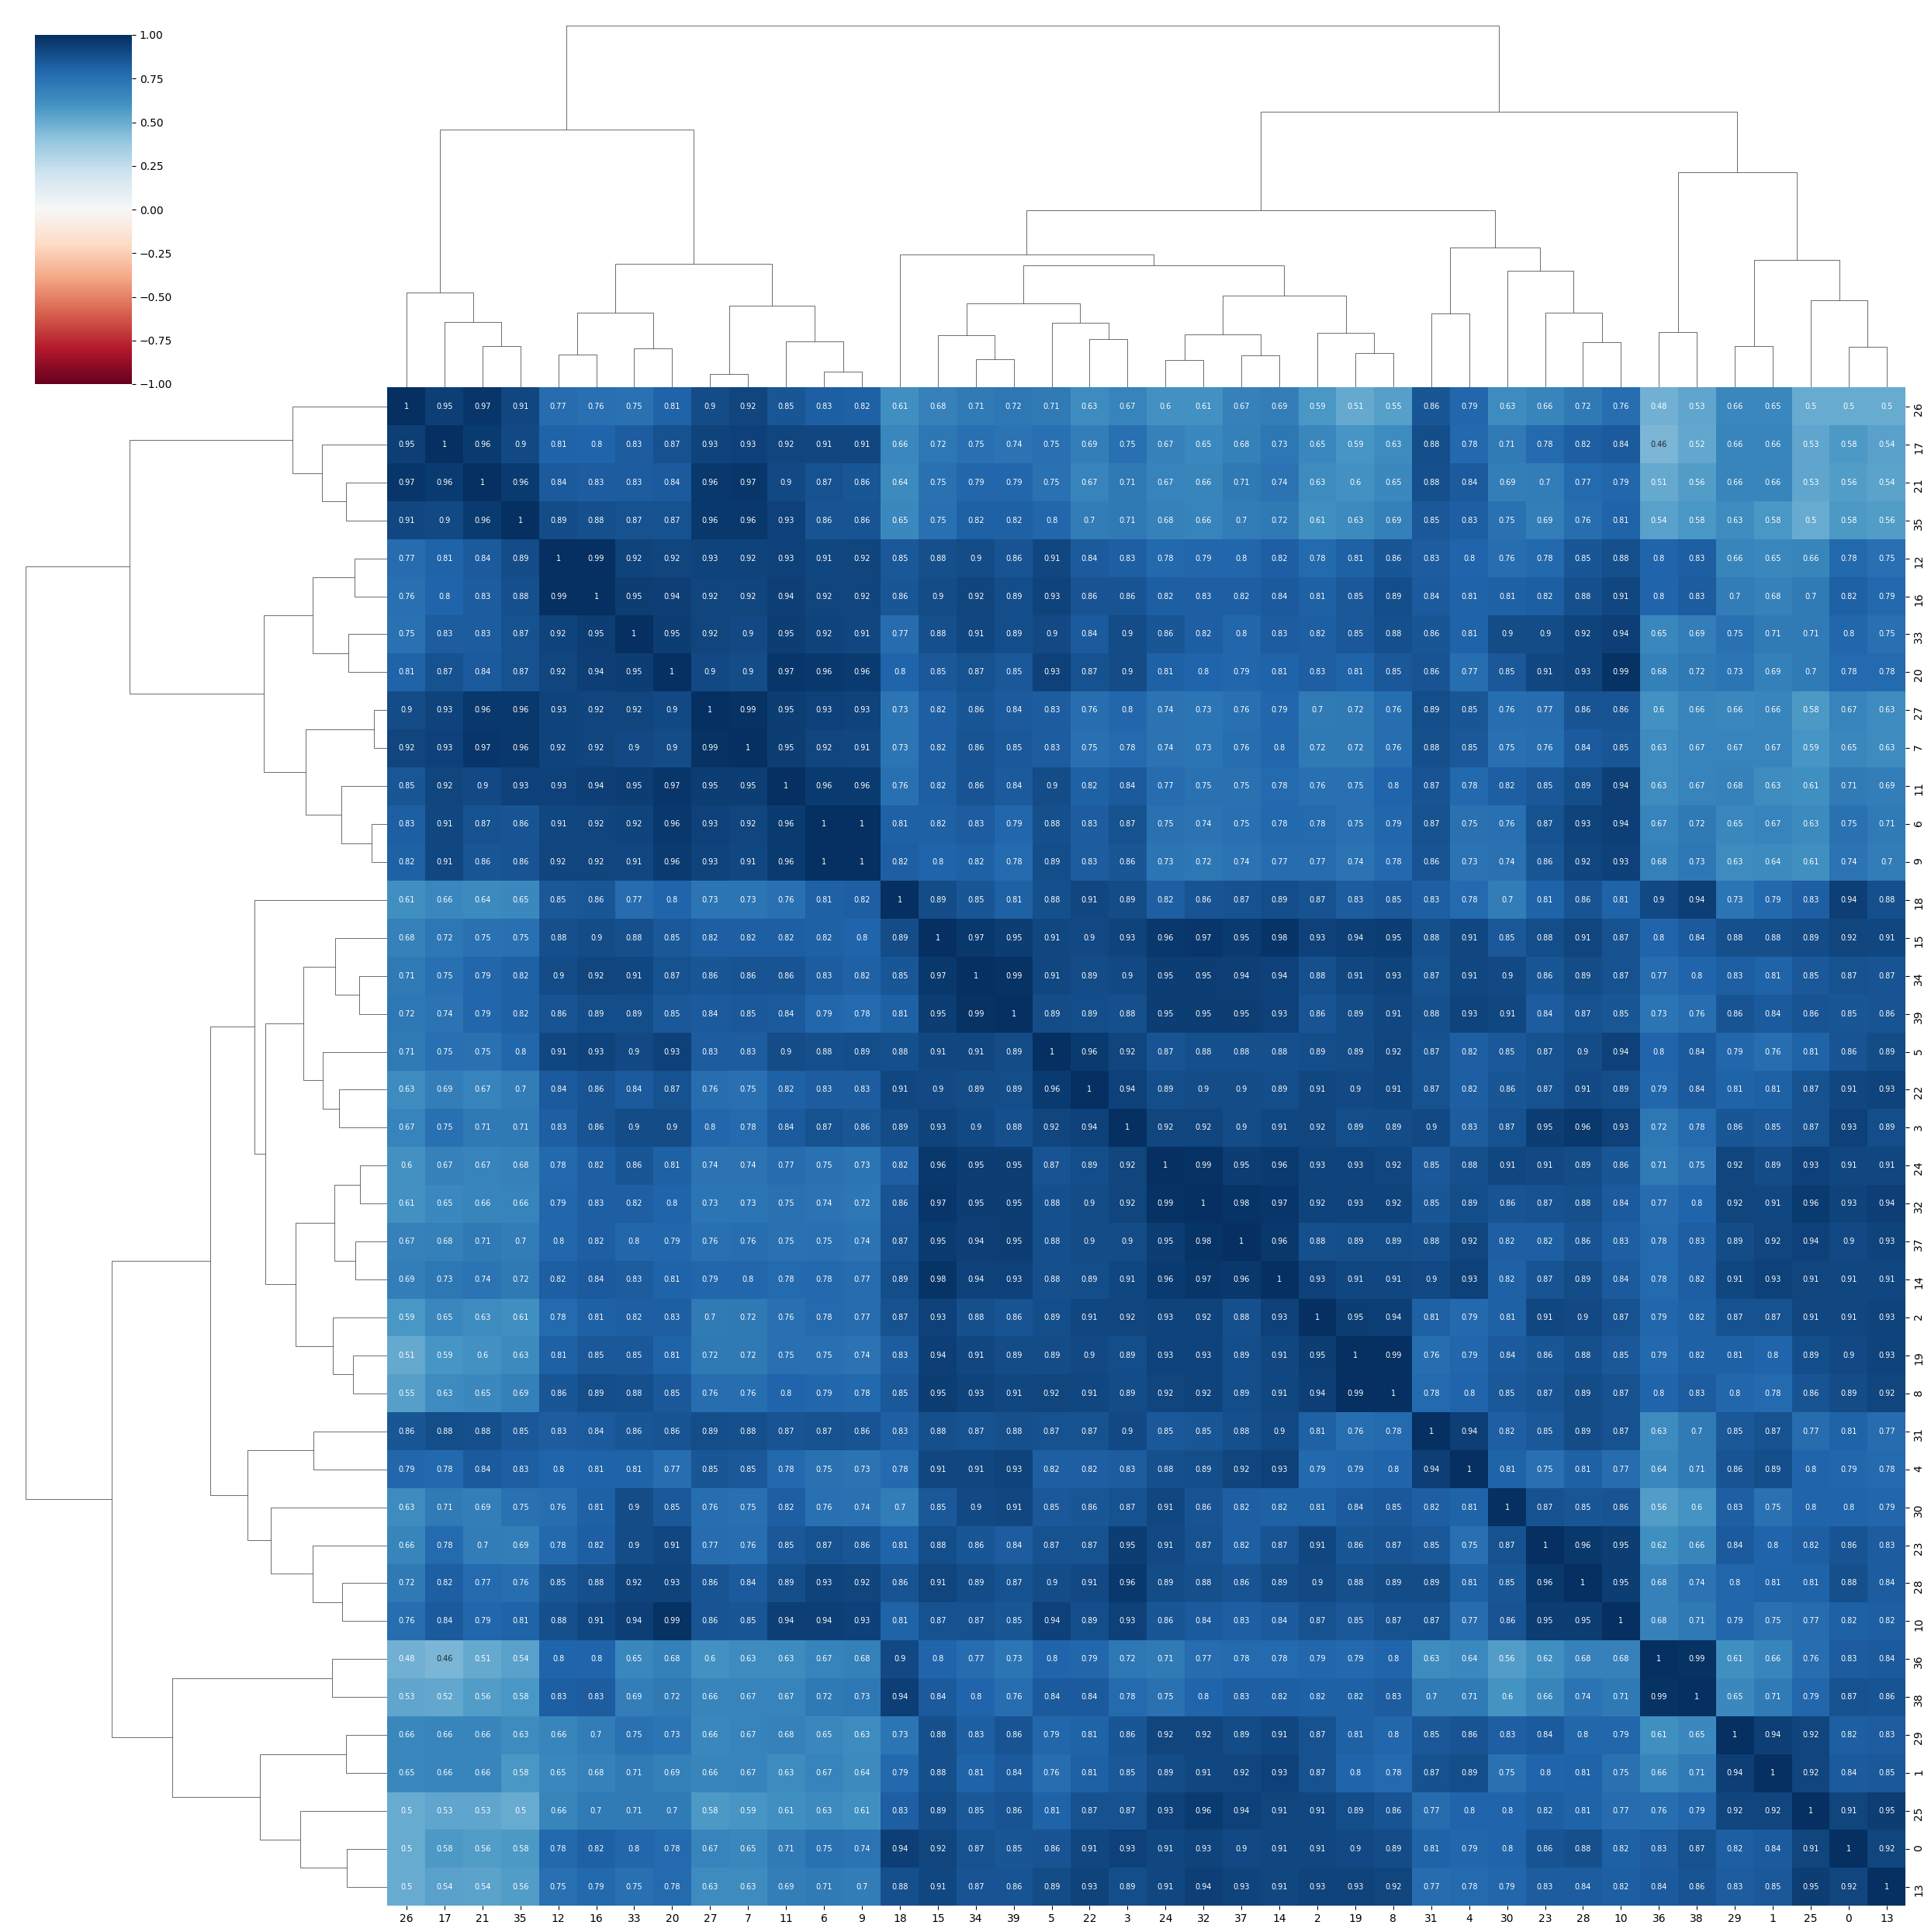

In [ ]:
sns.clustermap(correlations1, method="complete", cmap='RdBu', annot=True,
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(25,25));

<function matplotlib.pyplot.show(close=None, block=None)>

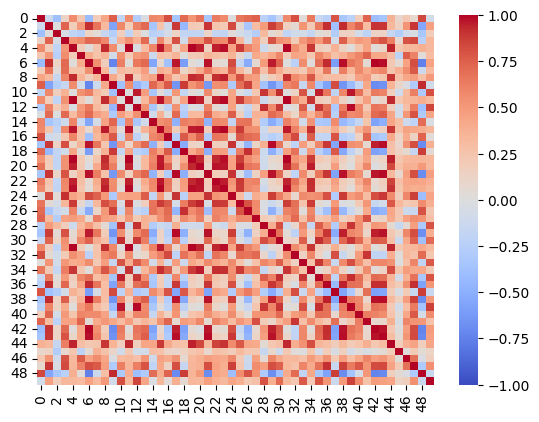

In [ ]:
#Análise dos valores do MAX
correlation_matrix2 = np.corrcoef(x_transformado[:,1:100:2].T)#todas as linhas, colunas de 1 a 36 pulando de 2 em 2(1,3,5,7,.. ímpares valores MAX)
sns.heatmap(correlation_matrix2, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.show

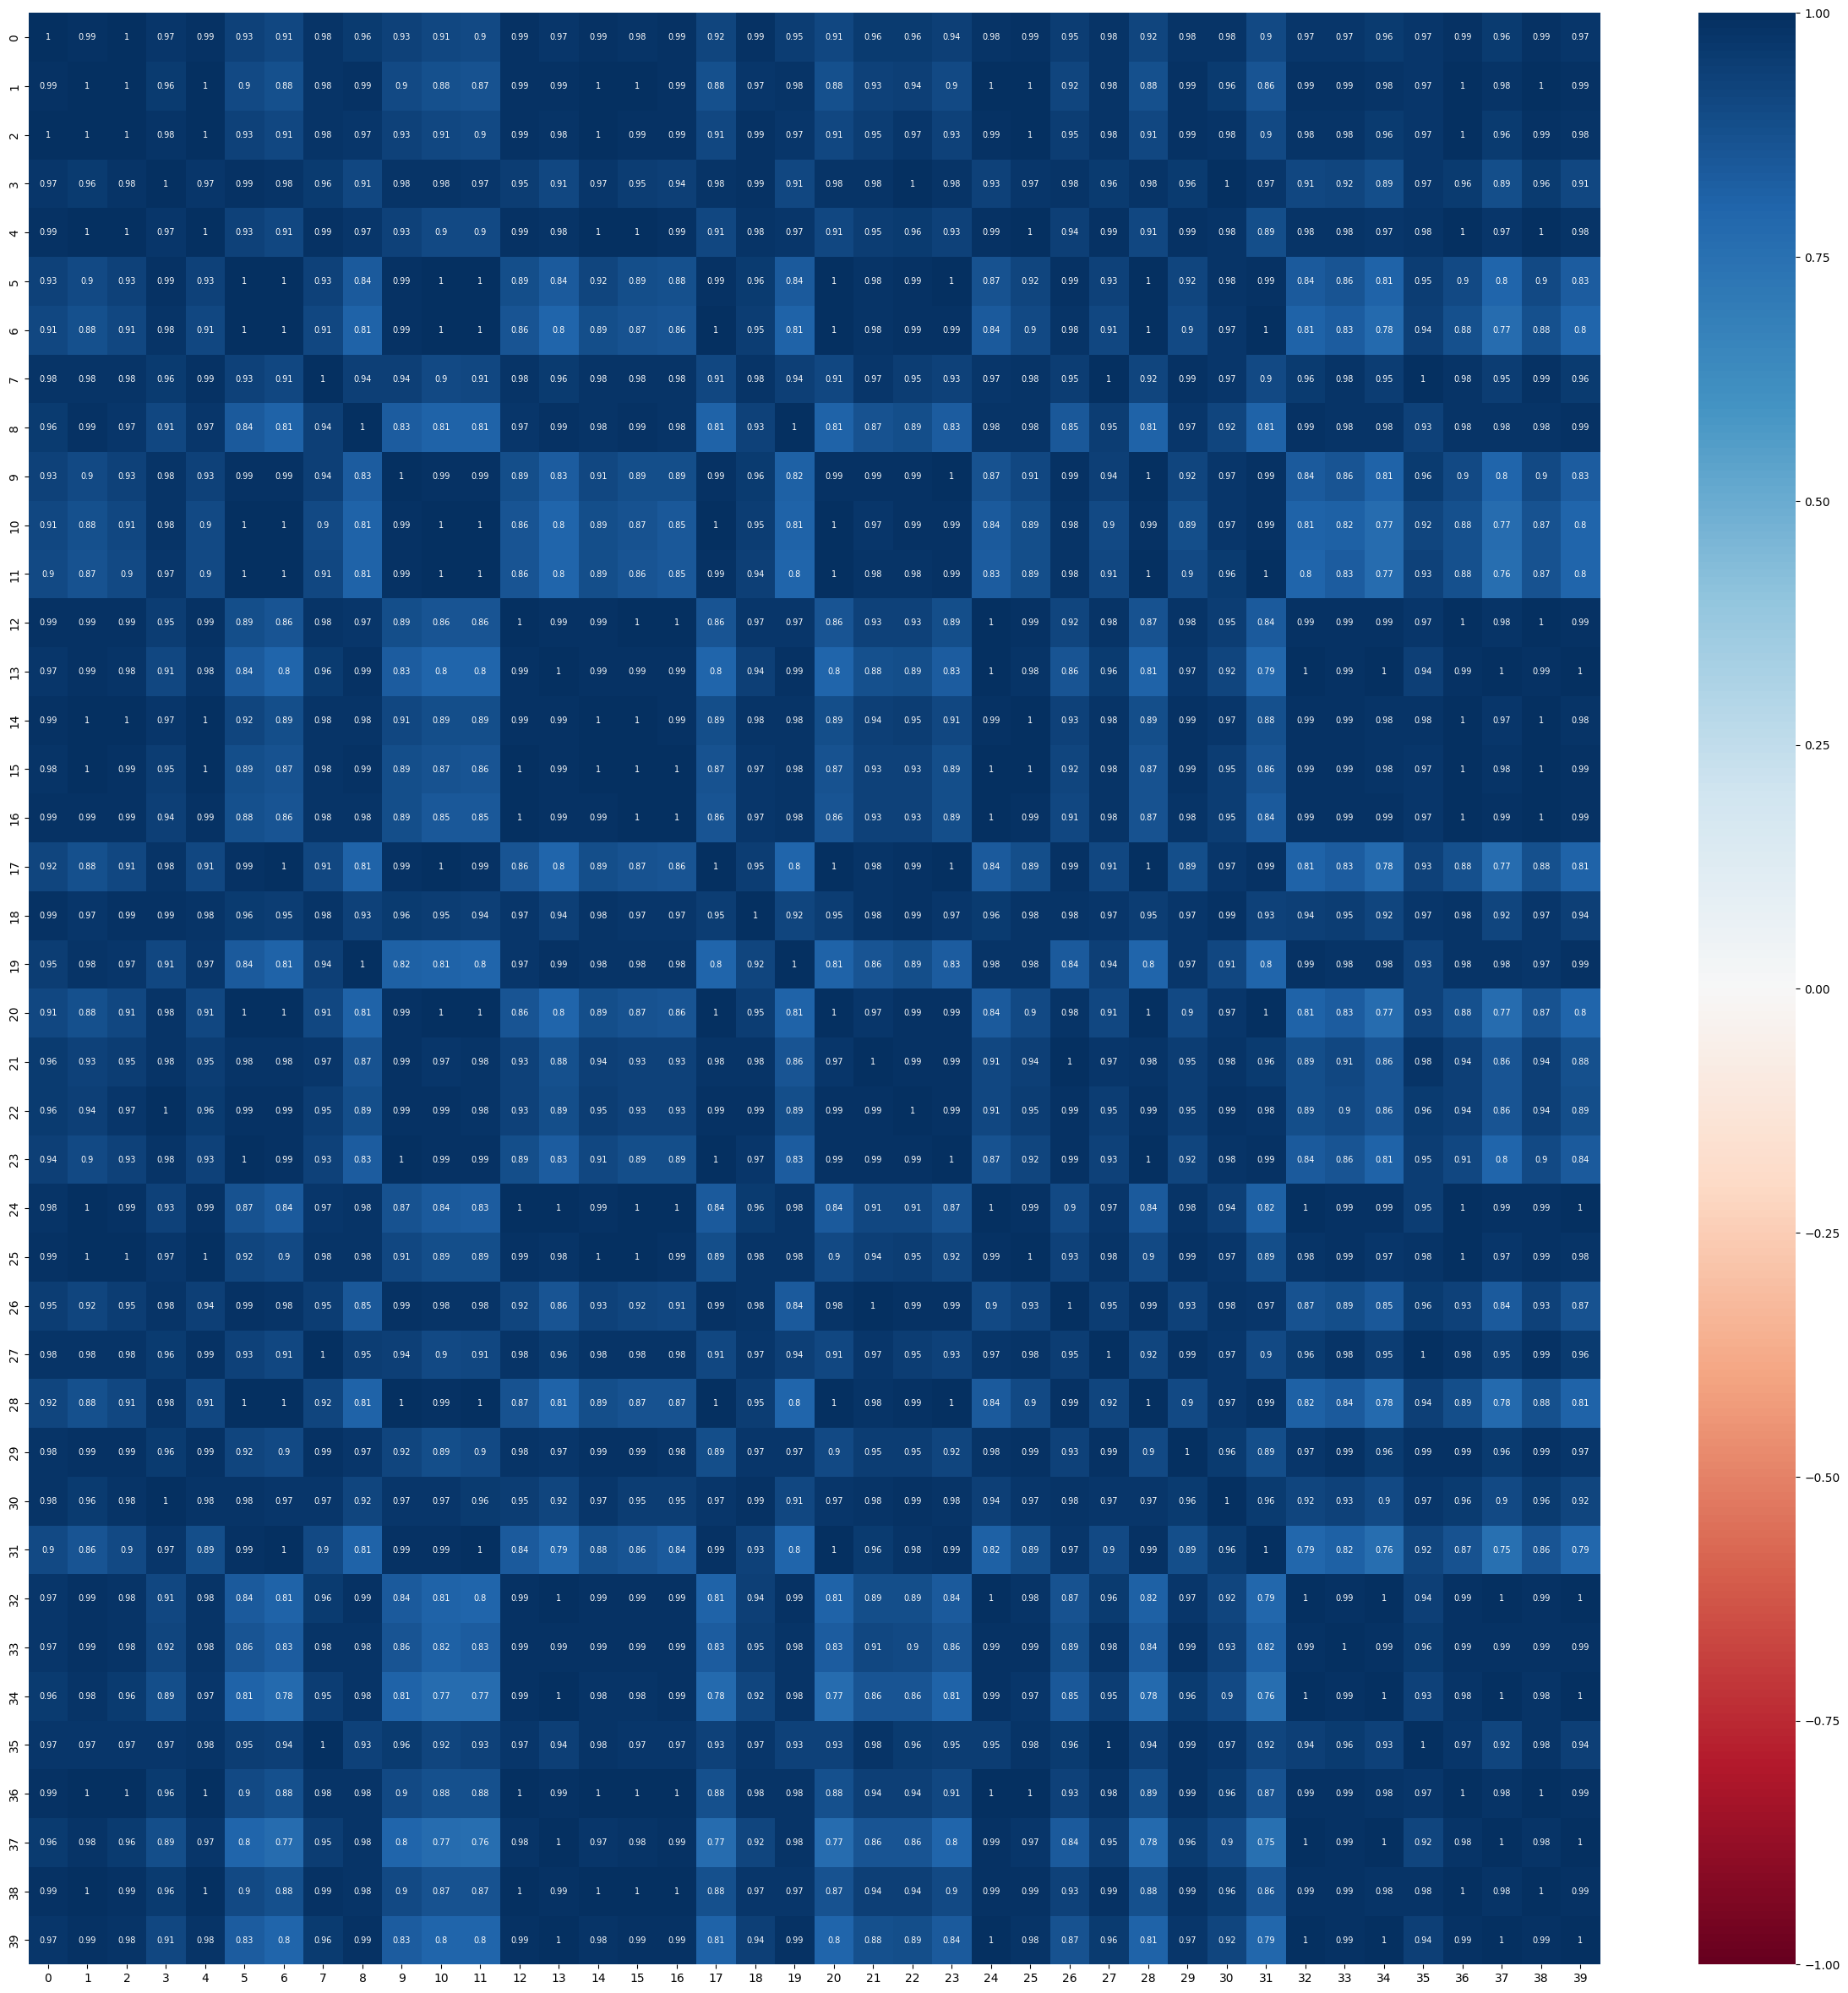

In [ ]:
ecg200max = pd.DataFrame(x_transformado[:,1:100:2].T)
plt.figure(figsize=(30,30))
correlations2 = ecg200max.corr()
sns.heatmap(round(correlations2,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);

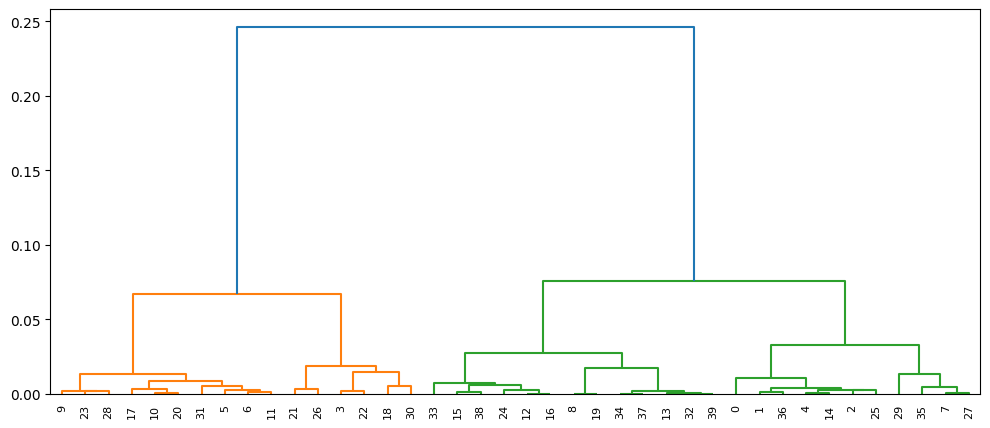

In [ ]:
plt.figure(figsize=(12,5))
dissimilarity2 = 1 - abs(correlations2)
Z = linkage(squareform(dissimilarity2), 'complete')

dendrogram(Z, labels=ecg200max.columns, orientation='top',
           leaf_rotation=90);

In [ ]:
# Clusterize the data
threshold = 0.000005
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

array([36, 30, 34, 13, 32,  9,  7, 37, 23,  3,  4,  8, 19, 29, 33, 17, 20,
        6, 15, 24,  5, 11, 14,  1, 21, 35, 12, 38,  2, 40, 16, 10, 27, 22,
       25, 39, 31, 26, 18, 28], dtype=int32)

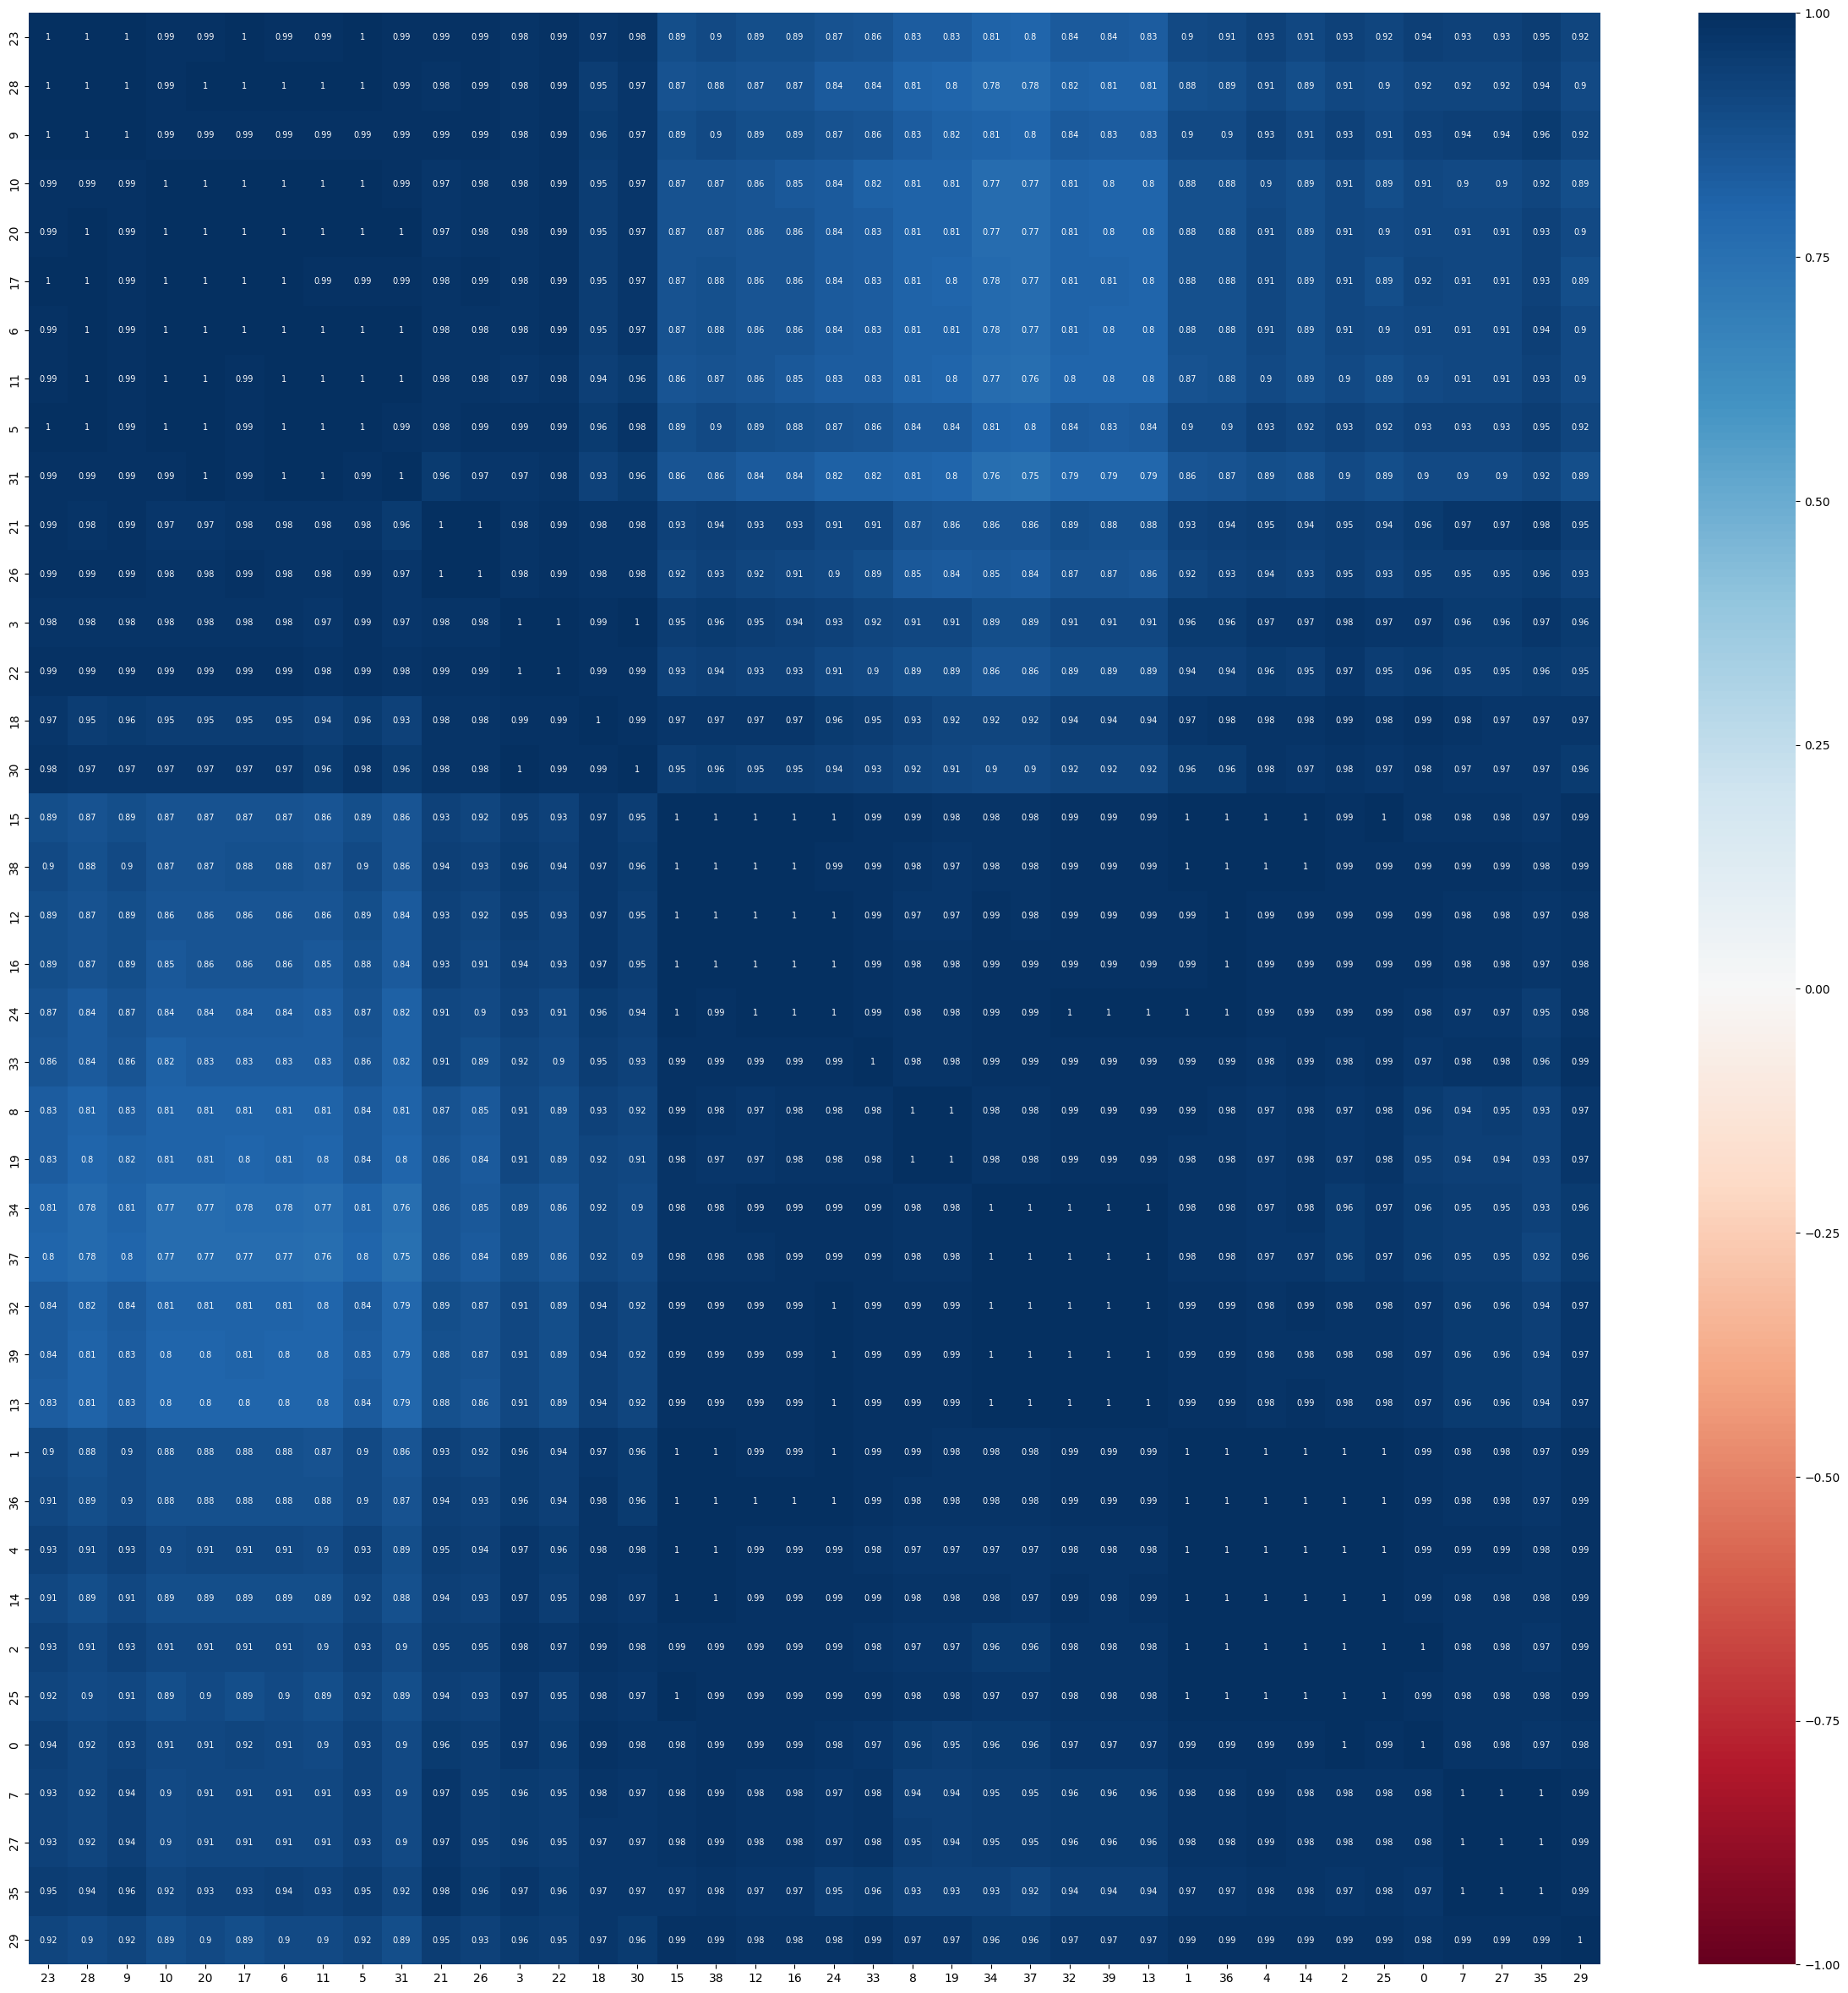

In [ ]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(ecg200max.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(ecg200max[i])
    else:
        df_to_append = pd.DataFrame(ecg200max[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

plt.figure(figsize=(30,30))
correlations2 = clustered.corr()
sns.heatmap(round(correlations2,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);

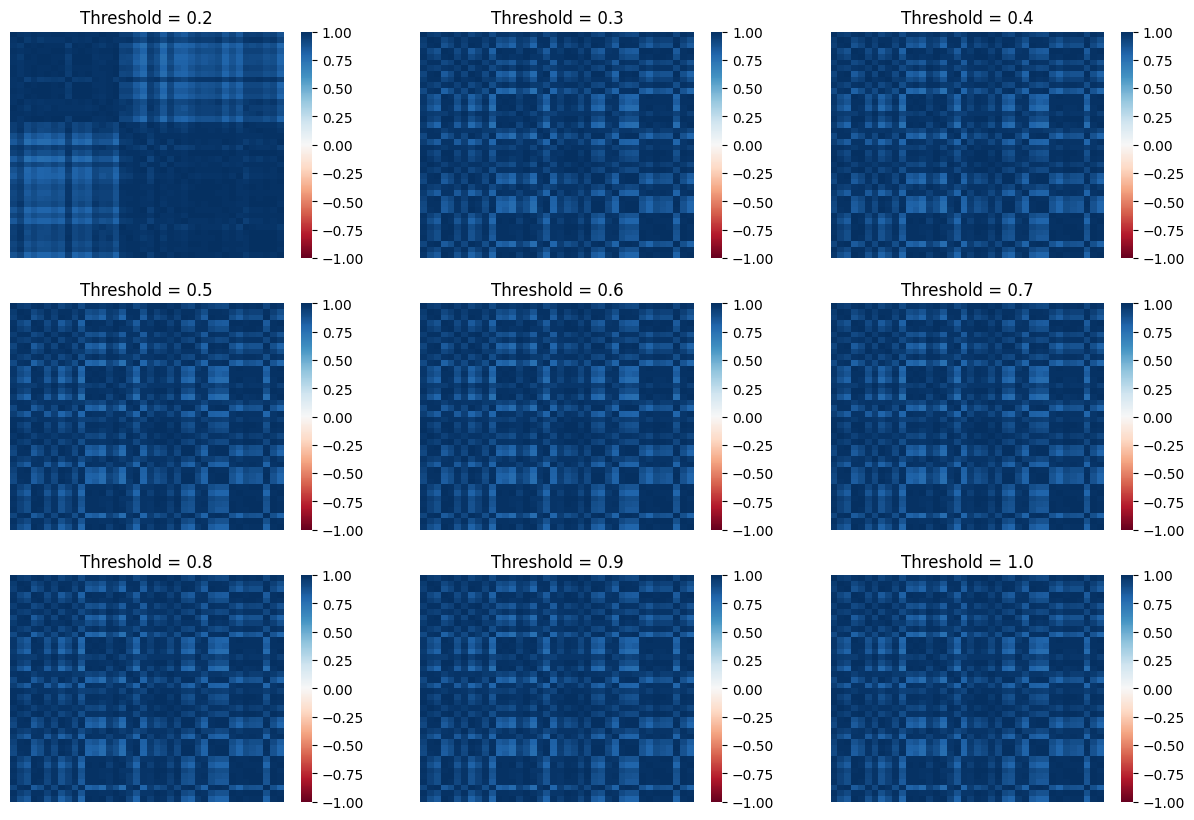

In [ ]:
plt.figure(figsize=(15,10))

for idx, t in enumerate(np.arange(0.2,1.1,0.1)):

    # Subplot idx + 1
    plt.subplot(3, 3, idx+1)

    # Calculate the cluster
    labels = fcluster(Z, t, criterion='distance')

    # Keep the indices to sort labels
    labels_order = np.argsort(labels)

    # Build a new dataframe with the sorted columns
    for idx, i in enumerate(ecg200max.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(ecg200max[i])
        else:
            df_to_append = pd.DataFrame(ecg200max[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)

    # Plot the correlation heatmap
    correlations2 = clustered.corr()
    sns.heatmap(round(correlations2,2), cmap='RdBu', vmin=-1, vmax=1,
                xticklabels=False, yticklabels=False)
    plt.title("Threshold = {}".format(round(t,2)))

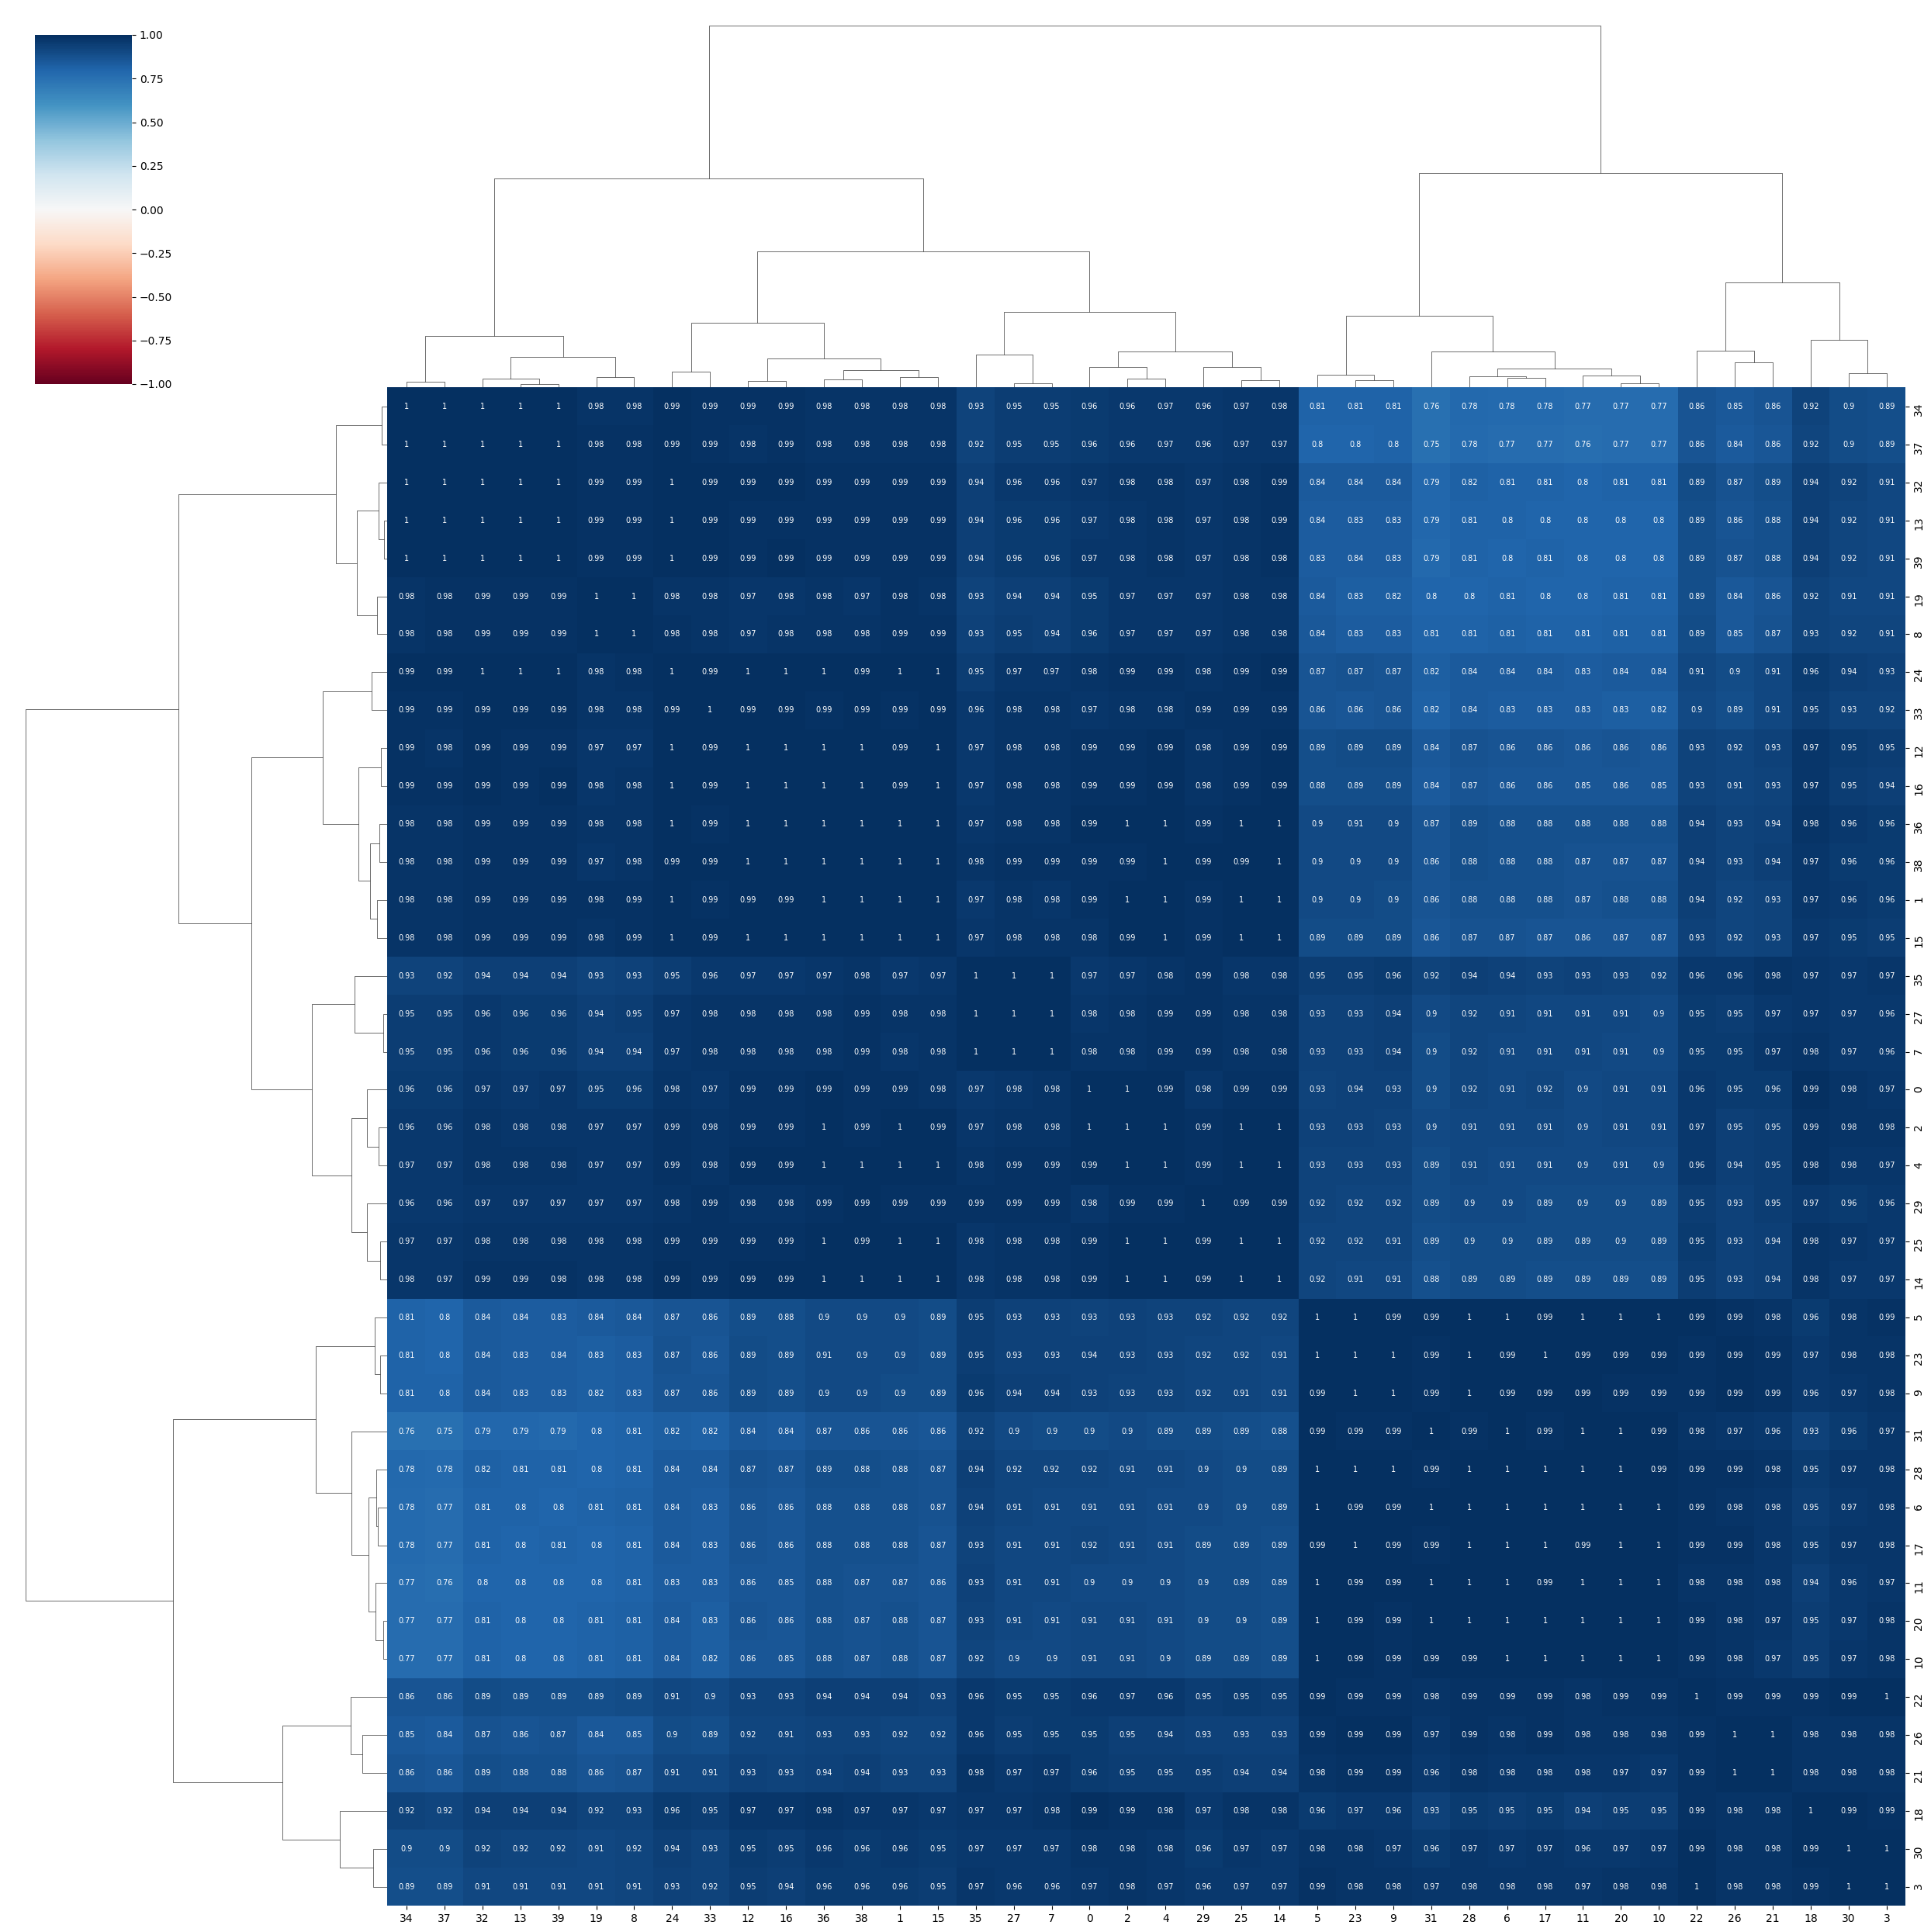

In [ ]:
sns.clustermap(correlations2, method="complete", cmap='RdBu', annot=True,
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(25,25));